# Validation - Star1NoNoise

Validation case to run **D2IC** on the DIC Challenge 2.0 Star1NoNoise image pair (reference + deformed) and visualize the displacement field.

Data used: `doc/img/Star1NoNoise/DIC_Challenge_Wave_Reference_NoiseFree.tif` (reference), `doc/img/Star1NoNoise/DIC_Challenge_Wave_Deformed_NoiseFree.tif` (deformed), and the ROI mask `doc/img/Star1NoNoise/roi.tif`.

Images courtesy of the DIC Challenge 2.0.


In [35]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
import sys

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib.tri import LinearTriInterpolator
import numpy as np
from skimage.io import imread

from D2IC.dic import Dic
from D2IC.dic_plotter import DICPlotter
from D2IC import generate_roi_mesh


jax.config.update("jax_platform_name", "gpu")


jax.devices()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[CudaDevice(id=0)]

## 1) Load 2 images + ROI mask

im_ref: (501, 2000) float32
im_def: (501, 2000) float32
mask : (501, 2000) uint8


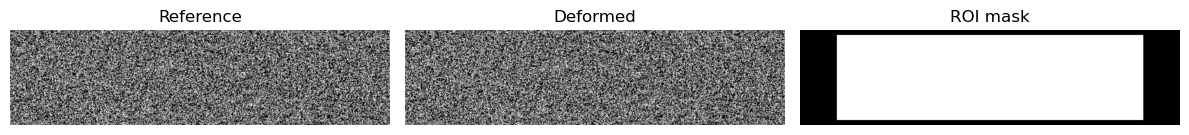

In [27]:

repo_root = None
current = Path.cwd().resolve()
for candidate in (current, *current.parents):
    img_root = candidate / "doc" / "img" / "Star1NoNoise"
    if img_root.exists():
        repo_root = candidate
        break
if repo_root is None:
    raise FileNotFoundError(
        "Could not locate the repository root (doc/img/Star1NoNoise folder missing)."
    )

img_dir = repo_root / "doc" / "img" / "Star1NoNoise"
out_dir = Path("./_outputs")
out_dir.mkdir(exist_ok=True)

im_ref = imread(img_dir / "DIC_Challenge_Wave_Reference_NoiseFree.tif").astype(np.float32)
im_def = imread(img_dir / "DIC_Challenge_Wave_Deformed_NoiseFree.tif").astype(np.float32)
mask = imread(img_dir / "roi.tif")[:,:,0]

print("im_ref:", im_ref.shape, im_ref.dtype)
print("im_def:", im_def.shape, im_def.dtype)
print("mask :", mask.shape, mask.dtype)

fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
ax[0].imshow(im_ref, cmap="gray", origin="lower")
ax[0].set_title("Reference")
ax[1].imshow(im_def, cmap="gray", origin="lower")
ax[1].set_title("Deformed")
ax[2].imshow(mask, cmap="gray", origin="lower")
ax[2].set_title("ROI mask")
for a in ax:
    a.axis("off")
plt.tight_layout()


## 2) Generate an ROI mesh (from the mask)

The mesh is generated once and reused in subsequent runs.

In [28]:
mask_path = img_dir / "roi.tif"
mesh_path = out_dir / "Star1NoNoise_validation_roi_mesh_40px.msh"


mesh_path_generated = generate_roi_mesh(mask_path, element_size=12.0, msh_path=str(mesh_path))
if mesh_path_generated is None:
    raise RuntimeError("Mesh generation failed.")
mesh_path = Path(mesh_path_generated)

mesh_path

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000294015s, CPU 0.00059s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Blossom: 17625 internal 348 closed
Info    : Blossom recombination completed (Wall 0.590593s, CPU 0.591346s): 5889 quads, 0 triangles, 0 invalid quads, 0 quads with Q < 0.1, avg Q = 0.844611, min Q = 0.483393
Info    : Done meshing 2D (Wall 0.679862s, CPU 0.68114s)
Info    : 6064 nodes 6241 elements
Info    : Writing '_outputs/Star1NoNoise_validation_roi_mesh_40px.msh'...
Info    : Done writing '_outputs/Star1NoNoise_validation_roi_mesh_40px.msh'


PosixPath('_outputs/Star1NoNoise_validation_roi_mesh_40px.msh')

## 3) Create the DIC object

We precompute pixel-level quantities (on the reference image).

In [29]:
dic = Dic(mesh_path=str(mesh_path))
dic.precompute_pixel_data(jnp.asarray(im_ref))

dic

## 4) Estimate an initial displacement (big motion)

D2IC can estimate an initial field using sparse correspondences (patch matching + RANSAC).

Retained matches: 7


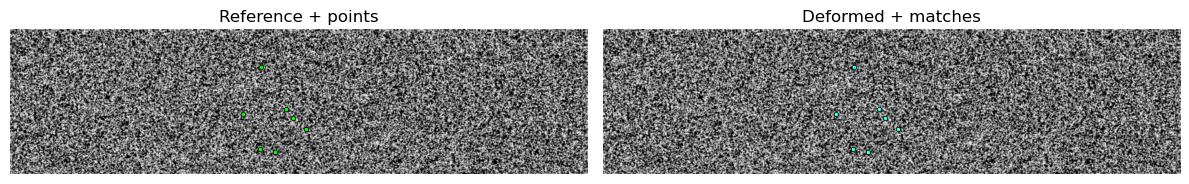

In [30]:
disp_guess, extras = dic.compute_feature_disp_guess_big_motion(
    im_ref,
    im_def,
    n_patches=32,
    patch_win=21,
    patch_search=15,
    refine=True,
    search_dilation=5.0,
)

pts_ref = extras["pts_ref"]
pts_def = extras["pts_def"]
print("Retained matches:", pts_ref.shape[0])

fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
ax[0].imshow(im_ref, cmap="gray", origin="lower")
ax[0].scatter(pts_ref[:, 0], pts_ref[:, 1], s=10, c="lime", edgecolors="k", linewidths=0.5)
ax[0].set_title("Reference + points")

ax[1].imshow(im_def, cmap="gray", origin="lower")
ax[1].scatter(pts_def[:, 0], pts_def[:, 1], s=10, c="cyan", edgecolors="k", linewidths=0.5)
ax[1].quiver(
    pts_ref[:, 0],
    pts_ref[:, 1],
    pts_def[:, 0] - pts_ref[:, 0],
    pts_def[:, 1] - pts_ref[:, 1],
    angles="xy",
    scale_units="xy",
    scale=1.0,
    color="yellow",
    width=0.003,
)
ax[1].set_title("Deformed + matches")

for a in ax:
    a.axis("off")
plt.tight_layout()

## 5) Solve global DIC

Pixelwise solve with spring regularization (`reg_type="spring"`).

[CG] iter   0  J=2.2057e+01  ||g||=1.469e+00
        alpha=1.000e+00, J_new=1.9961e+01
[CG] iter   1  J=1.9961e+01  ||g||=1.384e+00
        alpha=1.000e+00, J_new=1.8100e+01
[CG] iter   2  J=1.8100e+01  ||g||=1.304e+00
        alpha=1.000e+00, J_new=1.6448e+01
[CG] iter   3  J=1.6448e+01  ||g||=1.229e+00
        alpha=1.000e+00, J_new=1.4980e+01
[CG] iter   4  J=1.4980e+01  ||g||=1.159e+00
        alpha=1.000e+00, J_new=1.3674e+01
[CG] iter   5  J=1.3674e+01  ||g||=1.094e+00
        alpha=1.000e+00, J_new=1.2512e+01
[CG] iter   6  J=1.2512e+01  ||g||=1.032e+00
        alpha=1.000e+00, J_new=1.1477e+01
[CG] iter   7  J=1.1477e+01  ||g||=9.742e-01
        alpha=1.000e+00, J_new=1.0554e+01
[CG] iter   8  J=1.0554e+01  ||g||=9.200e-01
        alpha=1.000e+00, J_new=9.7313e+00
[CG] iter   9  J=9.7313e+00  ||g||=8.691e-01
        alpha=1.000e+00, J_new=8.9967e+00
[CG] iter  10  J=8.9967e+00  ||g||=8.214e-01
        alpha=1.000e+00, J_new=8.3404e+00
[CG] iter  11  J=8.3404e+00  ||g||=7.766e-0

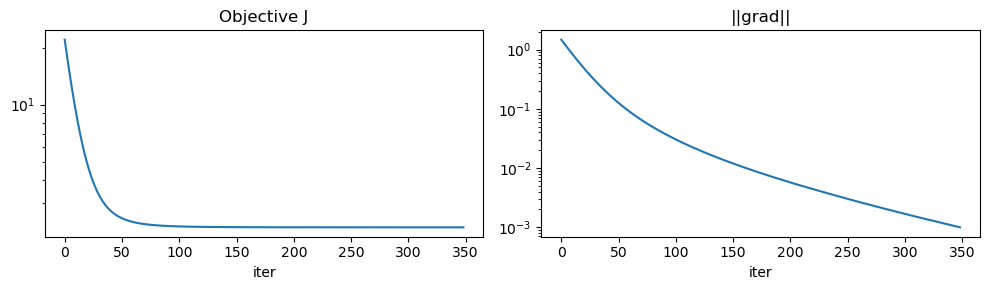

In [31]:
displacement, history = dic.run_dic(
    im_ref,
    im_def,
    disp_guess=disp_guess,
    max_iter=5000,
    tol=1e-3,
    reg_type="spring",
    alpha_reg=0.01,
)

hist = np.asarray(history)
print("Last state:", hist[-1])

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].semilogy(hist[:, 0])
ax[0].set_title("Objective J")
ax[0].set_xlabel("iter")
ax[1].semilogy(hist[:, 1])
ax[1].set_title("||grad||")
ax[1].set_xlabel("iter")
plt.tight_layout()

## 6) Visualize the displacement field

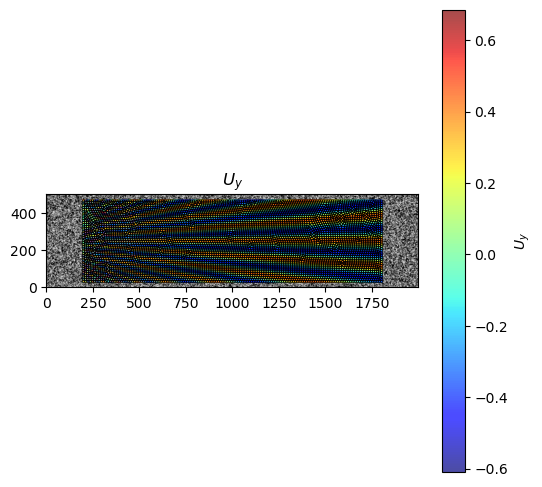

In [36]:
plotter = DICPlotter(
    background_image=im_def,
    displacement=np.asarray(displacement),
    dic_object=dic,
)

fig, _ = plotter.plot_displacement_component("Uy", image_alpha=0.7)
plt.show()

## 6bis) Mid-line displacement profile

Extract the displacement along the horizontal line $y = 250$ px and plot both $U_x$ and $U_y$ components.


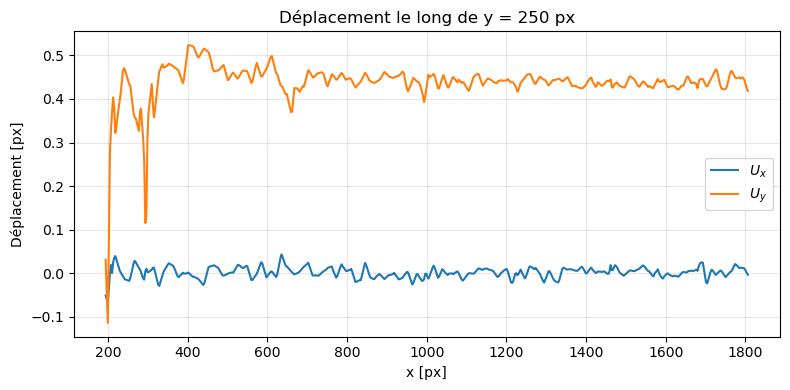

In [39]:
line_y = 250.0
triangulation = dic.get_mesh_as_triangulation()
ux_values = np.asarray(displacement[:, 0])
uy_values = np.asarray(displacement[:, 1])

interp_ux = LinearTriInterpolator(triangulation, ux_values)
interp_uy = LinearTriInterpolator(triangulation, uy_values)

x_min, x_max = float(triangulation.x.min()), float(triangulation.x.max())
x_line = np.linspace(x_min, x_max, 600)
y_line = np.full_like(x_line, line_y)

ux_line = np.ma.asarray(interp_ux(x_line, y_line)).filled(np.nan)
uy_line = np.ma.asarray(interp_uy(x_line, y_line)).filled(np.nan)

valid = np.isfinite(ux_line) & np.isfinite(uy_line)
if not np.any(valid):
    raise RuntimeError(f"The mesh does not intersect the line y={line_y} px.")

x_valid = x_line[valid]
ux_valid = ux_line[valid]
uy_valid = uy_line[valid]

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(x_valid, ux_valid, label=r"$U_x$")
ax.plot(x_valid, uy_valid, label=r"$U_y$")
ax.set_xlabel("x [px]")
ax.set_ylabel("Displacement [px]")
ax.set_title(f"Displacement along y = {line_y:.0f} px")
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()


## 7) (Optional) Local nodal refinement 

To obtain a smoother field 


[Nodal-spring_jacobi] sweep 1/10, J=1.4671e+00
[Nodal-spring_jacobi] sweep 2/10, J=1.4300e+00
[Nodal-spring_jacobi] sweep 3/10, J=1.4322e+00
[Nodal-spring_jacobi] sweep 4/10, J=1.4307e+00
[Nodal-spring_jacobi] sweep 5/10, J=1.4297e+00
[Nodal-spring_jacobi] sweep 6/10, J=1.4291e+00
[Nodal-spring_jacobi] sweep 7/10, J=1.4288e+00
[Nodal-spring_jacobi] sweep 8/10, J=1.4287e+00
[Nodal-spring_jacobi] sweep 9/10, J=1.4286e+00
[Nodal-spring_jacobi] sweep 10/10, J=1.4286e+00


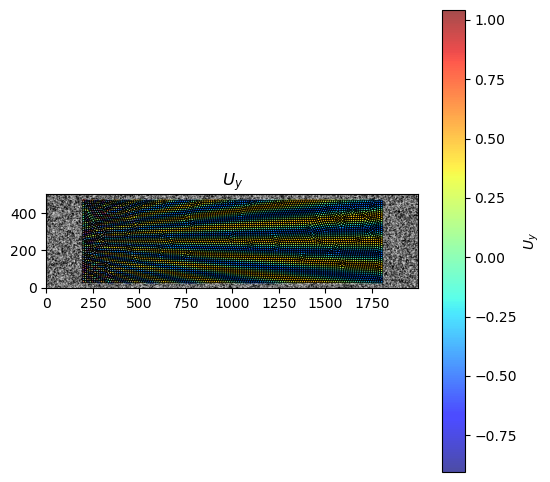

In [38]:
displacement_refined = dic.run_dic_nodal(
    im_ref,
    im_def,
    disp_init=displacement,
    n_sweeps=10,
    lam=0.1,
    reg_type="spring_jacobi",
    alpha_reg=1.0,
    max_step=0.2,
    omega_local=0.5,
)

plotter = DICPlotter(
    background_image=im_def,
    displacement=np.asarray(displacement_refined),
    dic_object=dic,
)
fig, _ = plotter.plot_displacement_component("Uy", image_alpha=0.7)
plt.show()